In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip', '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果你使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

# 整理数据集

In [3]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


In [4]:
labels

{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

## 先在训练文件夹中，创建名为`类`的子文件夹，将同`类`图片放入其中


## 定义`reorg_train_valid`函数，将验证集从原始的训练集中拆分出来

- 此函数中的参数valid_ratio是验证集中的样本数与原始训练集中的样本数之比。 
    - 更具体地说，令等于样本最少的类别中的图像数量，而是比率。 
- 验证集将为每个类别拆分出张图像。
- 以valid_ratio=0.1为例，由于原始的训练集有50000张图像，因此train_valid_test/train路径中将有45000张图像用于训练，而剩下5000张图像将作为路径train_valid_test/valid中的验证集。
- 组织数据集后，同类别的图像将被放置在同一文件夹下。

In [5]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):    # 训练集：来自于train图片集。用于训练模型
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))   # train_valid：cifar10原始的train文件。调完参数后，在完整的训练集上，训练一遍，会后测试
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))    # 验证集：来自于train图片集。用于看结果并调参
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [6]:
## 在预测期间整理测试集，以方便读取
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))    # 因为label不知道，所以放在unknown文件夹下面

## 定义函数来调用前面定义的函数
- read_csv_labels、reorg_train_valid和reorg_test
- 将样本数据集的批量大小设置为32
    - 在实际训练和测试中，应该使用Kaggle竞赛的完整数据集，并将batch_size设置为更大的整数，例如128。 
- 将10％的训练样本作为调整超参数的验证集

- 实际100G的图片集，因占用空间，不能copy分类
    - 可用`Customerized iterate`

In [13]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)
    
    
# batch_size = 32 if demo else 128
batch_size = 64
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [8]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像（32x32）放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])


# 我们只对图像执行标准化，以消除评估结果中的随机性。
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## 读取由原始图像组成的数据集
- 之所以分开写，是因为train做了aug，valid没做

In [9]:
# train_valid_ds和valid_ds的用途不一样，
# valid_ds和train_ds配合，train_ds训练，valid_ds验证。
# 再使用train_valid_ds全部做训练

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

### 指定上面定义的所有图像增广操作

In [14]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

# 训练集drop last的可以丢，测试集不能丢（对每个图片做预测）
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

# 定义模型

In [11]:
# （10：最后一层的类别数，3：（输入是RGB3）通道）
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

# 训练函数
- 根据模型在验证集上的表现来选择模型并调整超参数。 
- 定义了模型训练函数train
- wd：weight decay对应统计模型
- lr decay：对应优化模型
- `torch.optim.lr_scheduler.StepLR`
    - r_period, lr_decay：学习率下降的方法，每隔5个data epoch, 降低学习率减少0.5
- 随机梯度下降的前提是学习率要不断的减少，之所以减少，是因为在迭代最靠经最优解的时候，不要乱走（抖动）
- 一个批量的样本有方差，批量越大方差越小。方差是一个噪音
- 方差的好处是不容易陷入局部最优解，坏处是带偏

In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    # lr_scheduler：每隔lr_period个epoch，当前lr乘以lr_decay
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        # 每个epoch之后，要step更新一下。因为已经把trainer丢给了schedual，所以schedual可以访问lr，再对学习率做相应的变化
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## 训练和验证模型
- 当lr_period和lr_decay分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9

train loss 1.069, train acc 0.605, valid acc 0.328
1287.6 examples/sec on [device(type='cuda', index=0)]


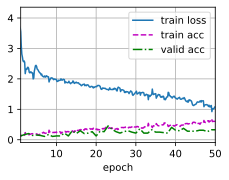

In [20]:
# devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 0.002, 0.005
# 每隔4个epoch之后，当前lr = 之前lr乘以0.9
lr_period, lr_decay, net = 10, 0.9, get_net()    # 0.375
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## 对测试集进行分类并提交结果

train loss 1.088, train acc 0.604
1310.2 examples/sec on [device(type='cuda', index=0)]


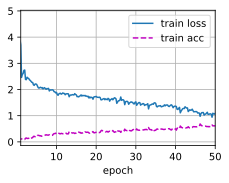

In [21]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# 预测
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission-cifar10tiny.csv', index=False)